# Estimating the effect of agricultural conservation practices (CP) on reducing nutrient loss

We will use the Measured Annual Nutrient loads from AGricultural Environments (MANAGE) data from the USDA,
as published by [Qian and Harmel](https://onlinelibrary.wiley.com/doi/epdf/10.1111/1752-1688.12377), where they used causal inference in order to quantify the effects of water and soil conservation practices in reducing phosphorus loss from agricultural fields.

The data is [provided](https://onlinelibrary.wiley.com/action/downloadSupplement?doi=10.1111%2F1752-1688.12377&file=jawr12377-sup-0001-manage.RData) in `Rdata` format, so we will first have to load it and transform it. 
We use the `rpy2` package, which is not a part of the requirements for `causallib` and so you will have to install it if reproducing the analysis.

## Loading the data

In [1]:
import rpy2.robjects as objects
import pandas as pd

In [5]:
url = objects.r['url']('https://onlinelibrary.wiley.com/action/downloadSupplement?doi=10.1111%2F1752-1688.12377&file=jawr12377-sup-0001-manage.RData')
try:
    objects.r['load'](url)
except Exception:  # fallback - if the above doesn't work please download the file directly
    objects.r['load']('jawr12377-sup-0001-manage.rdata')

R[write to console]: Error in (function (file, envir = parent.frame(), verbose = FALSE)  : 
  cannot open the connection to 'https://onlinelibrary.wiley.com/action/downloadSupplement?doi=10.1111%2F1752-1688.12377&file=jawr12377-sup-0001-manage.RData'

R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: In (function (file, envir = parent.frame(), verbose = FALSE)  :
R[write to console]: 
 
R[write to console]:  cannot open URL 'https://onlinelibrary.wiley.com/action/downloadSupplement?doi=10.1111%2F1752-1688.12377&file=jawr12377-sup-0001-manage.RData': HTTP status was '503 Service Unavailable'

R[write to console]: Error in readChar(con, 5L, useBytes = TRUE) : cannot open the connection

R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: In readChar(con, 5L, useBytes = TRUE) :
R[write to console]: 
 
R[write to console]:  cannot open compressed file 'jawr12377-sup-0001-manage.rdata', probable reason '

RRuntimeError: Error in readChar(con, 5L, useBytes = TRUE) : cannot open the connection


In [ ]:
# normally we would use pandas to transform the R-datafram into a pandas dataframe, 
# from rpy2.robjects import pandas2ri
# pandas2ri.activate() 
# but in many versions of pandas this is broken with categorical data as we have here
# so instead we will use R to save the DataFrame to csv and load it in pandas
objects.r['write.csv'](x=objects.r["LoadApr2007"], file="MANAGE.csv", fileEncoding="UTF-8", **{"row.names": False})
manage = pd.read_csv("MANAGE.csv", index_col='RecordID')
print(manage.shape)
manage.head()

(274, 71)


,WatershedID,City,State,Location,Date,Watershed.Years,ShortLU,LandUse,Tillage,CP1,...,PP.Form,MaxTPLoad,MinTPLoad,AvgTPLoad,FormTP,FlowIndicator,Comments,Reference,Ref,CPs
RecordID,,,,,,,,,,,,,,,,,,,,,
151,4 Yr. Bahiagrass 1,"Tifton, GA",GA,NaN,1952 - 1960,4,Pasture,"1st Yr. Bahiagrass, Clover (4 Yr. Rotation of ...",Pasture,NaN,...,NaN,NaN,NaN,NaN,NaN,Surface Runoff,NaN,"Thomas, A.W., R.L. Carter, and J.R. Carreker. ...",44,0
152,4 Yr. Bahiagrass 2,"Tifton, GA",GA,NaN,1952 - 1960,4,Pasture,"2nd Yr. Bahiagrass, Clover (4 Yr. Rotation of ...",Pasture,NaN,...,NaN,NaN,NaN,NaN,NaN,Surface Runoff,NaN,"Thomas, A.W., R.L. Carter, and J.R. Carreker. ...",44,0
260,KA-1,"Middleton, WI",WI,NaN,2003-2004,2,Alfalfa,Alfalfa,Pasture,NaN,...,NaN,0.12,0.12,0.12,NaN,Surface Runoff,NaN,"Cabot, P.E., K.G. Karthikeyan, P.S. Miller, an...",7,0
261,KA-2,"Middleton, WI",WI,NaN,2003-2004,2,Alfalfa,Alfalfa,Pasture,NaN,...,NaN,2.21,0.03,1.12,NaN,Surface Runoff,Flow from outside the watershed may have contr...,"Cabot, P.E., K.G. Karthikeyan, P.S. Miller, an...",7,0
93,C7,"Chickasha, OK",OK,NaN,July 1972 - June 1973,1,Alfalfa,Alfalfa (Dryland),Pasture,NaN,...,NaN,NaN,NaN,2.48,NaN,Surface Runoff,"Estimated precipitation, runoff, and soil loss...","Olness, A., S.J. Smith, E.D. Rhoades, and R.G....",29,0


## Data pre-processing
We will follow the [procedure used by Qian and Harmel](https://onlinelibrary.wiley.com/action/downloadSupplement?doi=10.1111%2F1752-1688.12377&file=jawr12377-sup-0002-causalClean.R)
to preprocess the data, which includes creating a few log-transforms and cleaning the data.

The intervention we are interested in is one of either contour farming, terracing, buffering, or creating a waterway.
Together these are referred to as conservation practices, or CP.
The outcome of interest is the amount of phosphorus that was measured in runoff water (`AvgTPLoad`). 
To see why this is a problems see [an explanation from the USGS](https://www.usgs.gov/special-topic/water-science-school/science/phosphorus-and-water) and [from the EPA](https://www.epa.gov/nutrient-policy-data/estimated-total-nitrogen-and-total-phosphorus-loads-and-yields-generated-within).


In [ ]:
import numpy as np
#manage.fillna(manage.median(axis=0), inplace=True)
manage["AvgTPLoad"].clip(0.002, inplace=True)
manage["AvgTNLoad"].clip(0.02, inplace=True)
manage["F.AppMethod1"].replace("Other", "Surface Applied", inplace=True)
manage["F.AppMethod1"].replace("Other2", "Unknown", inplace=True)

manage["CFarm"] = (manage[["CP1", "CP2", "CP3"]] == "Contour Farming").any(axis=1)
manage["Buffer"] = ((manage[["CP1", "CP2", "CP3"]] == "Filter Strip").any(axis=1)) | \
                   ((manage[["CP1", "CP2", "CP3"]] == "Riparian Buffer").any(axis=1))
manage["Terrace"] = (manage[["CP1", "CP2", "CP3"]] == "Terrace").any(axis=1)
manage["Waterway"] = (manage[["CP1", "CP2", "CP3"]] == "Waterway").any(axis=1)
manage["NumCP"] = manage[["CFarm", "Buffer", "Terrace", "Waterway"]].sum(axis=1)
manage["AnyCP"] = manage[["CFarm", "Buffer", "Terrace", "Waterway"]].any(axis=1)

manage.dropna(axis=1, thresh=50, inplace=True)

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

def boxplot(df:pd.DataFrame, name:str, by="AnyCP", ax=None):
    """A helper function to plot boxplots in log scale and annotate the median"""
    ax = ax or plt.gca()
    _ = df.boxplot(name, by=by, ax=ax)
    ax.set_yscale('log')
    ax.autoscale()
    ax.grid(False)
    medians = df[name].groupby(df[by]).median().values
    ticks = ax.get_xticklabels()
    for median, tick in zip(medians, ticks):
        ax.text(x=tick.get_position()[0], y=median, s=median, horizontalalignment="center")

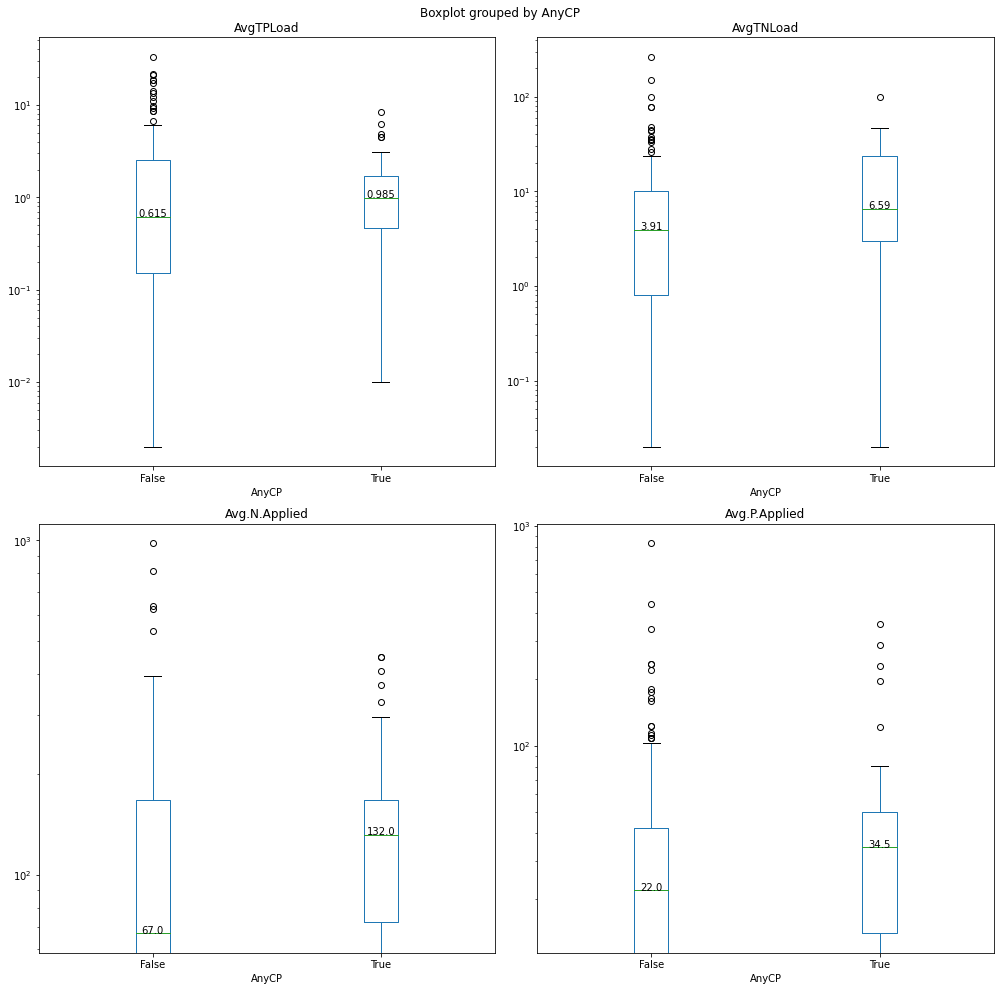

In [ ]:
fig, axes = plt.subplots(2, 2)
fig.set_size_inches(14,14)
boxplot(manage, "AvgTPLoad", ax=axes[0][0])
boxplot(manage, "AvgTNLoad", ax=axes[0][1])
boxplot(manage, "Avg.N.Applied", ax=axes[1][0])
boxplot(manage, "Avg.P.Applied", ax=axes[1][1])
plt.tight_layout()

## Causal inference
The box-plots above show both the outcome and several features are correlated with the treatment, which indicates that there is some bias in the data. We will now use causallib to estimate the effect of treatment by correcting for these biases.

As features, we use the amount of phosphorus and nitrogen applied, the total amount of water runoff, the soil volume, the phosphosros application method, and the type of land use (LU).

In [ ]:
from causallib.estimation import IPW
from sklearn.linear_model import LogisticRegression

In [ ]:
lr = LogisticRegression(solver='lbfgs', max_iter=500)
ipw = IPW(lr)

In [ ]:
y = np.log(manage["AvgTPLoad"])

a = manage["AnyCP"]

X = pd.DataFrame({"Runoff": np.log(manage["Avg.Runoff"]),
                  "Soil": np.log(manage["Avg.SoilL"] + 1),
                  "PApplied": np.log(manage["Avg.P.Applied"] + 1),
                  "NApplied": np.log(manage["Avg.N.Applied"] + 1)})
X = pd.concat([X, pd.get_dummies(manage["F.AppMethod1"], prefix="Method"), 
               pd.get_dummies(manage["ShortLU"], prefix="LU"),
               pd.get_dummies(manage["Tillage"], prefix="Tillage")], axis=1)
X.fillna(X.median(axis=0), inplace=True)

y = y.dropna()  # remove the data where there is no outcome
a, X = a[y.index], X.loc[y.index]

print(X.shape)
X.head()

(222, 23)


,Runoff,Soil,PApplied,NApplied,Method_Incorporated,Method_Injected,Method_Surface Applied,Method_Unknown,LU_Alfalfa,LU_Corn,...,LU_Other,LU_Pasture,LU_Peanuts,LU_Rotation,LU_Sorghum,LU_Soybeans,Tillage_Conservation,Tillage_Conventional,Tillage_No Till,Tillage_Pasture
RecordID,,,,,,,,,,,,,,,,,,,,,
260,0.009950,4.529368,3.288402,4.430817,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,1
261,1.615420,4.726502,3.288402,4.430817,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,1
93,5.010635,5.525453,3.806662,3.713572,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,1
68,3.295837,1.609438,3.157000,4.430817,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,1
259,1.308333,6.669498,3.465736,4.430817,0,0,1,0,0,0,...,1,0,0,0,0,0,0,1,0,0


In [ ]:
ipw.fit(X, a)  # train the propensity model to apply causal inference 

IPW(clip_min=None, clip_max=None, use_stabilized=False,
    learner=LogisticRegression(max_iter=500))

In [ ]:
pd.DataFrame({"causal": np.exp(ipw.estimate_population_outcome(X, a, y)),
              "marginal": np.exp(y.groupby(a).mean())})

,causal,marginal
AnyCP,,
False,0.695621,0.592249
True,0.515510,0.798039


We can see that the causal inference identifies that using any CP will reduce the phosphorus load, while the marginal observation (just checking what happened in treated vs. untreated areas) shows the opposite trend. How can this be?
## Evaluation and adjustments
One way to understand what is occurring is to evaluate the performance of the propensity model and check how consistent it is. Causallib provides the tools to do this.

In [ ]:
from causallib.evaluation import evaluate

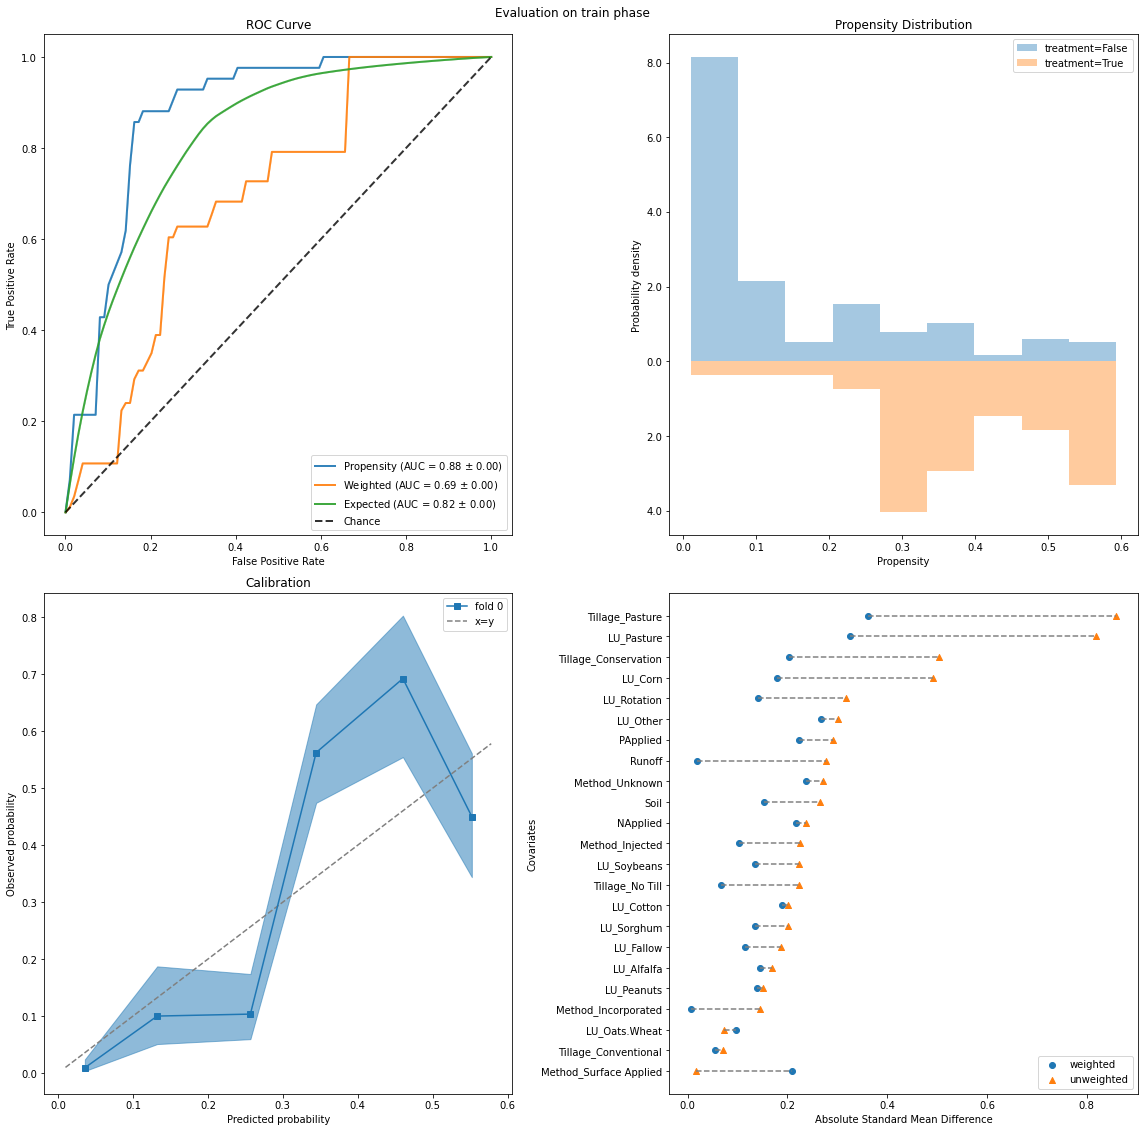

In [ ]:
evaluation_results = evaluate(ipw, X, a, y)
evaluation_results.plot_all()
plt.tight_layout()

At first glance it might seem that while the model has good predictive performance in the ROC curve (top left). However, the fact that the weighted ROC curve is far from the diagonal hints that the model is in fact not very good at balancing the data. This can also be seen in the covariate balancing plot (bottom right), where we see that the `Pasture` variable, which was extremely biased in the data, is still quite biased even after weighting. It would make sense, therefore, to stratify the analysis according to it, or to remove it from the analysis completely.

To check whether it is better to stratify or limit our analysis to a specific strata, let's check the overlap between `Pasture` and the treatment. We may as well look at all the categorical features and check:

In [ ]:
pd.concat({col: pd.crosstab(X[col], a) for col in X.select_dtypes('uint8').columns.values}, axis=0)

AnyCP                                       False  True 
                       Method_Incorporated              
Method_Incorporated    0                      148     31
                       1                       32     11
Method_Injected        0                      171     36
                       1                        9      6
Method_Surface Applied 0                      139     32
                       1                       41     10
Method_Unknown         0                       82     27
                       1                       98     15
LU_Alfalfa             0                      175     42
                       1                        5      0
LU_Corn                0                      156     24
                       1                       24     18
LU_Cotton              0                      173     42
                       1                        7      0
LU_Fallow              0                      179     40
                       1                        1      2
LU_Oats.Wheat          0                      162     39
                       1                       18      3
LU_Other               0                      165     42
                       1                       15      0
LU_Pasture             0                       99     41
                       1                       81      1
LU_Peanuts             0                      176     42
                       1                        4      0
LU_Rotation            0                      160     30
                       1                       20     12
LU_Sorghum             0                      175     38
                       1                        5      4
LU_Soybeans            0                      180     40
                       1                        0      2
Tillage_Conservation   0                      157     24
                       1                       23     18
Tillage_Conventional   0                      120     26
                       1                       60     16
Tillage_No Till        0                      168     35
                       1                       12      7
Tillage_Pasture        0                       95     41
                       1                       85      1

We see that there is only one case of pasture land that was in fact treated. We should limit the analysis only to non-pasture land. 

But it's a bit more than that, since treatment was also never observed for Alfalfa, Cotton, Peanuts, or Other. For Other, the difference is quite large while the others might still be attributed to small number fluctuations. While this could be tested using some sort of statistical test, this is not the focus of this example, and we will simply remove all these samples (and then remove the columns to avoid having all-zero columns).

In [ ]:
X = X.query('LU_Pasture == 0 & LU_Other == 0 & LU_Cotton ==0 & LU_Alfalfa == 0 & LU_Peanuts ==0 & LU_Soybeans == 0')
X = X.drop(columns=['LU_Pasture', 'LU_Other', 'LU_Cotton', 'LU_Alfalfa', 'LU_Peanuts', 'LU_Soybeans'])
a, y = a[X.index], y[X.index]
print(f'We are left with {len(y)} samples')
ipw.fit(X, a)
pd.DataFrame({"causal": np.exp(ipw.estimate_population_outcome(X, a, y)),
              "marginal": np.exp(y.groupby(a).mean())})

We are left with 107 samples


,causal,marginal
False,1.450745,1.436078
True,0.698854,0.826860


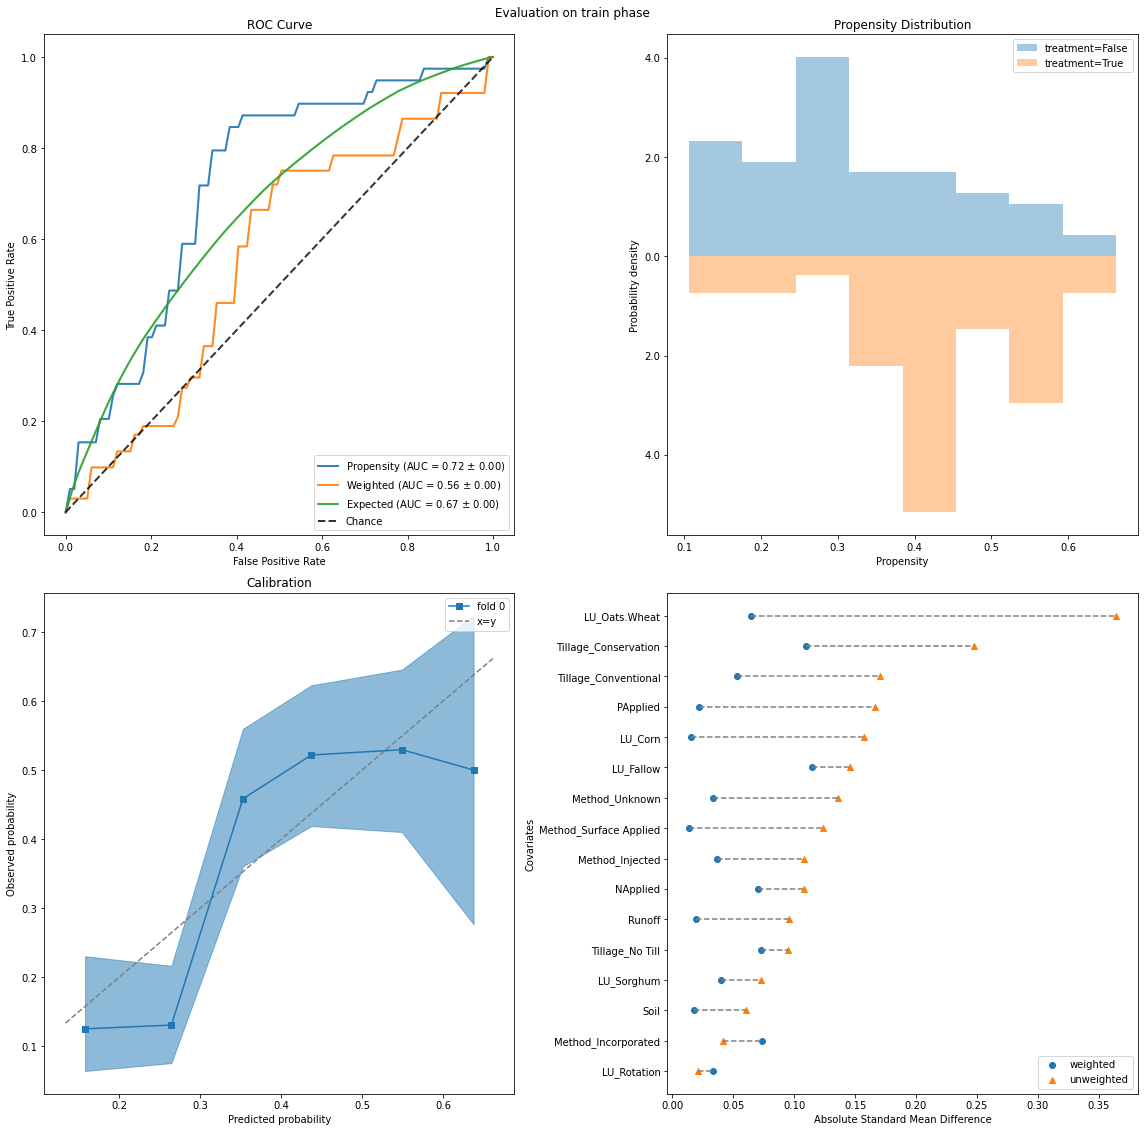

In [ ]:
evaluation_results = evaluate(ipw, X, a, y)
evaluation_results.plot_all()
plt.tight_layout()

Performance evaluation is much better now: 
- all the features are sufficiently balanced
- the model is as calibrated as can be expected given the small sample size that we now have
- the propensity distribution doesn't exhibit any areas with only one treatment group dominsating
- the ROC curves behave well.

Most importantly, after limiting the data the causal analysis agrees with the marginal analysis, and only makes a small adjustment to the causal effect size that is estimated. 

## Summary
In summary, the causal analysis allowed us to focus on where the data allows us to check differences between treatment groups. Indeed, unlike the initial analysis, we now understand that in non-pasture lands the conservation procedures of terracing, buffering, waterway, or contour farming actually improve phosphorus retention in the soil and reduce phosphorus leaking into the watershed when growing crops such as oats, wheat, corn, soybean and sorghum. While we can surmise that this may be true for other crops, we simply cannot answer that from the data.

### Acknowledgement
We would like to thank Biance Zadrozny, Sr. Manager, Spatiotemporal Modeling
IBM Research Brazil, for valuable feedback regarding the validity of the analyis and interpretation of the data and the results.